In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from pandas.plotting import table

np.random.seed(101)

In [2]:
DATA_PATH = "data/annotated_data/"
OCCUPATIONS_NAMES = pd.Series(["Fitness Instructor","Lawyer","Bartender","Financial Analyst","Cook",
                                "Dentist","Biological Scientist","Secondary School Teacher",
                                "Pharmacist","Janitor"])
OCCUPATIONS = pd.Series(["Fitness Instructor","Lawyer","Bartender","Financial Analyst","Cook",
                                "Dentist","Biological Scientist","Secondary School Teacher",
                                "Pharmacist","Janitor"]).str.lower().str.replace(" ","_")

In [3]:
annotations = []
for fp in os.listdir(DATA_PATH):
    author = re.match("(.+)Annotations.csv",fp).groups()[0]
    annotations += [pd.read_csv(DATA_PATH+fp).iloc[:,1:].set_index("Img").rename(columns={"Gender":f"{author}_Gender".format()})]

In [4]:
male_counts = (pd.concat(annotations,axis=1) == "Male").sum(axis=1)
# Number of non-unanimous results
print(male_counts[(male_counts != 0) & (male_counts != 5)].shape[0])
# Number of non-unanimous results likely attributed to human error
print(male_counts[(male_counts == 1) | (male_counts == 4)].shape[0])
# Number of non-unanimous results that may be contentious
print(male_counts[(male_counts == 2) | (male_counts == 3)].shape[0])

208
172
36


In [5]:
df = (male_counts >= 3).reset_index()
df.columns = ["Img","is_male"]

In [6]:
proportions = {}
sample_dist = {}
p_vals = {}

for occupation in OCCUPATIONS:
    data_subset = df[df["Img"].str.contains(occupation)]
    
    obs = np.mean(data_subset["is_male"])
    proportions[occupation] = obs
    obs = np.abs(.5 - np.mean(data_subset["is_male"]))
    sample_stats = np.abs(.5 - np.random.choice([True,False],(data_subset.shape[0],1000000,)).mean(axis=0))
    sample_dist[occupation] = {"obs":obs,"samples":sample_stats}
    p_vals[occupation] = np.mean(sample_stats >= obs)

In [7]:
p_df = pd.Series(p_vals)
p_df.index = OCCUPATIONS_NAMES
p_df = p_df.reset_index()
p_df.columns = ["Occupation","P-Value"]
p_df.to_csv("data/plot_data/p_values.csv",index=False)

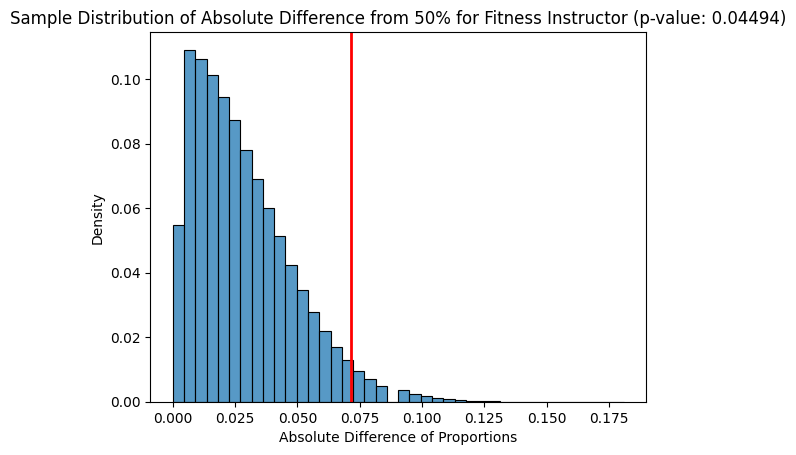

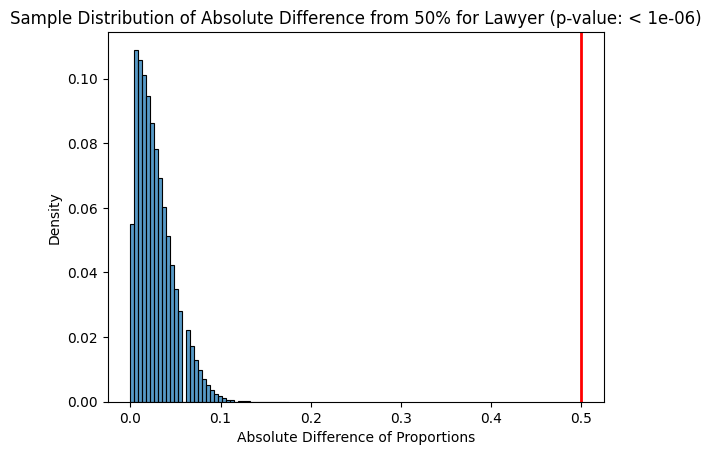

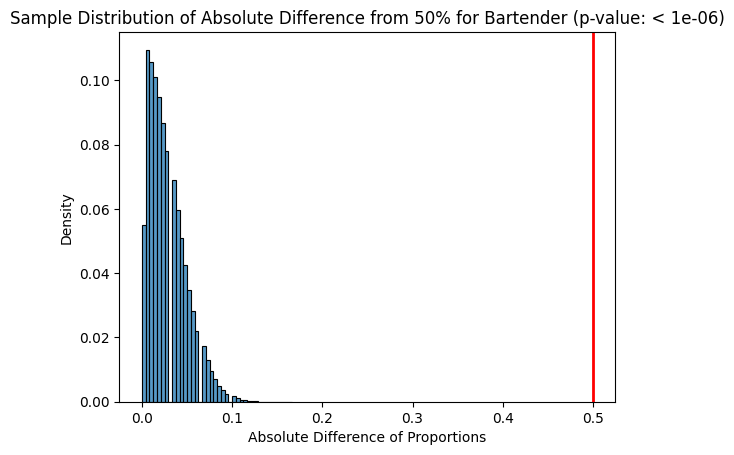

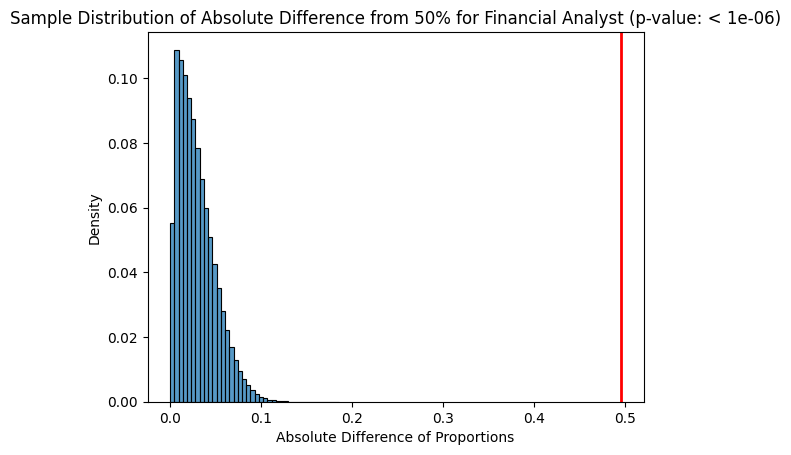

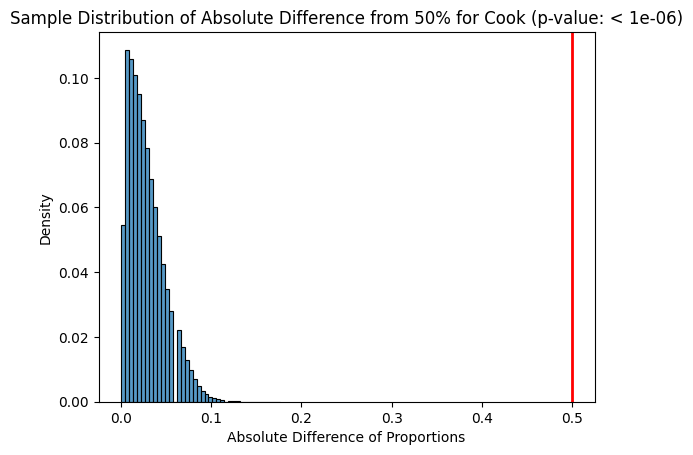

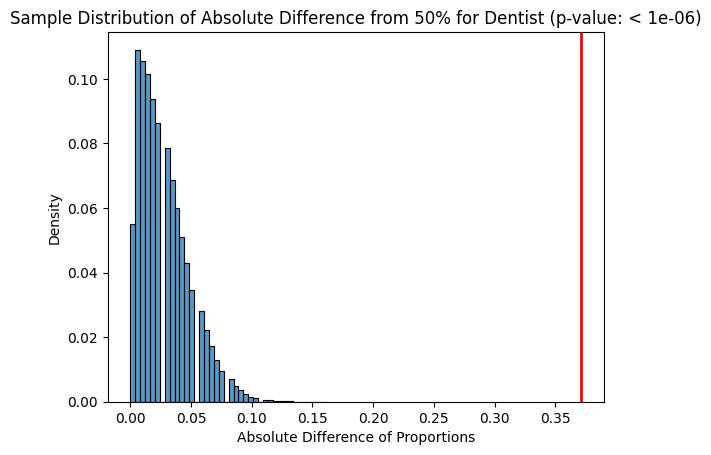

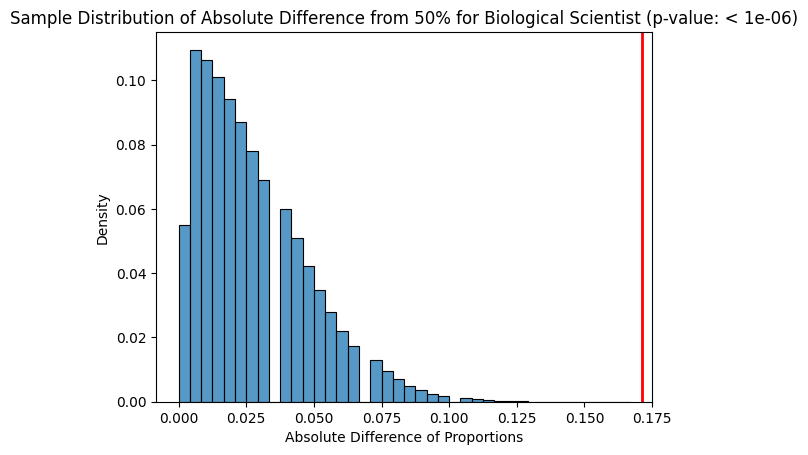

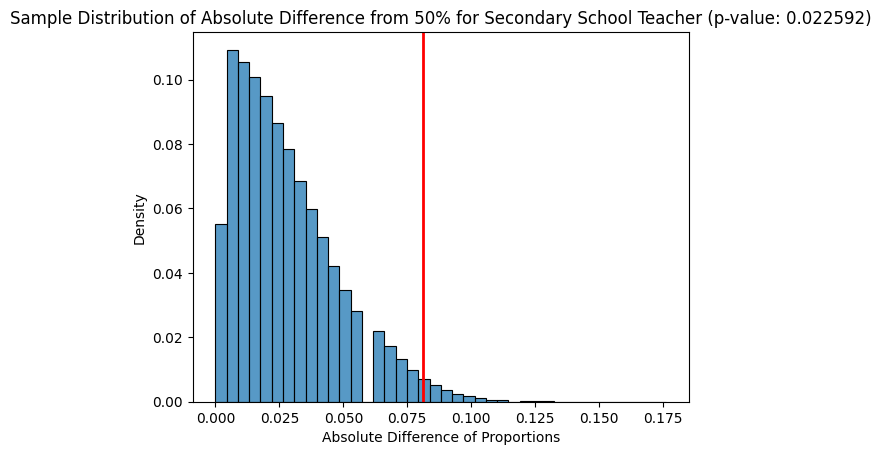

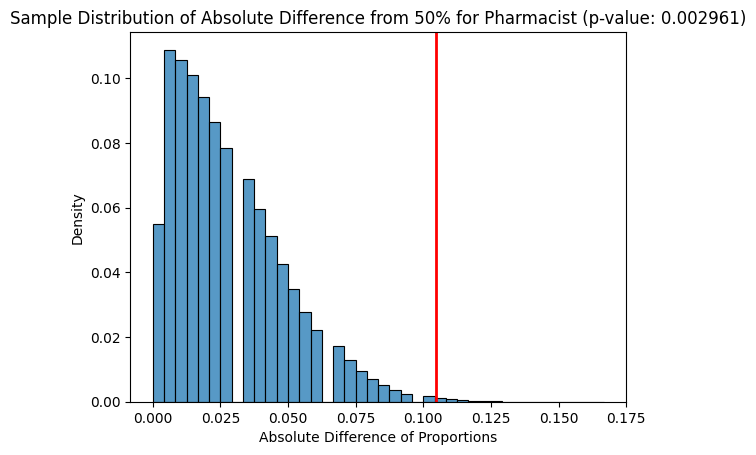

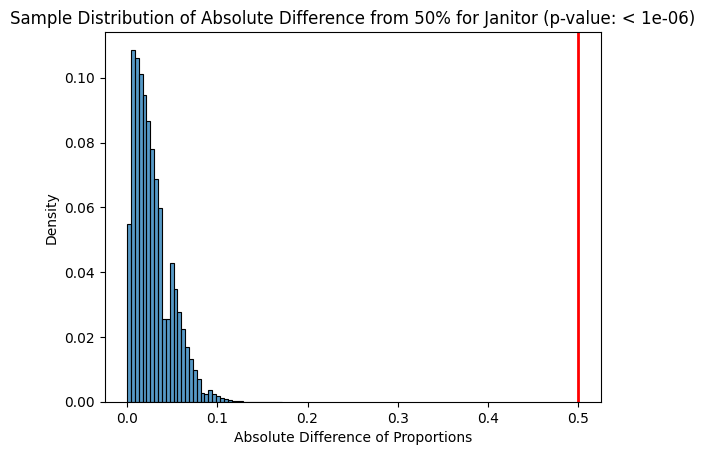

In [8]:
for occupation_name in OCCUPATIONS_NAMES:
    occupation = occupation_name.lower().replace(" ","_")
    p_value = p_vals[occupation]
    p_value = p_value if p_value > 0 else "< 1e-06"
    obs, sample_stats = (sample_dist[occupation]["obs"],sample_dist[occupation]["samples"])
    hist = sns.histplot(sample_stats,stat = "probability",bins=40)
    ax = hist.axes
    plt.axvline(x=obs, color='red', linewidth=2);
    plt.title(f"Sample Distribution of Absolute Difference from 50% for {occupation_name} (p-value: {p_value})",)
    ax.set(xlabel='Absolute Difference of Proportions', ylabel='Density')
    plt.savefig(f"./data/plot_data/{occupation}_plot",bbox_inches='tight')
    plt.show()